In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import pymc3 as pm
import matplotlib.pylab as plt

sns.set_style('white')

DATA = '../data/clean/'

In [2]:
line_list = pd.read_csv(DATA + 'line_list.csv')
line_list.head()

,id,date_onset,provincecity,dob,age_years,died,confirmed,labconfirmed,date_lab,vaccine_ever,male,month_onset,year_onset
0,389.0,2015-03-30,UB,2014-09-01,0.577686,0.0,1.0,1.0,2015-04-06,0.0,True,3.0,2015.0
1,707.0,2015-04-03,UB,2013-02-02,2.162902,1.0,1.0,1.0,2015-04-04,0.0,True,4.0,2015.0
2,1762.0,2015-04-14,KhU,2015-01-04,0.279261,1.0,1.0,0.0,NaN,0.0,True,4.0,2015.0
3,2061.0,2015-04-22,UB,2014-09-23,0.577686,0.0,1.0,1.0,2015-04-24,0.0,True,4.0,2015.0
4,6465.0,2015-05-12,UB,2013-12-18,1.314168,1.0,0.0,0.0,NaN,0.0,False,5.0,2015.0


In [3]:
confirmed_counts = pd.read_csv(DATA + 'confirmed_counts.csv', index_col=0)
confirmed_counts.tail()

,"[0, 5)","[5, 10)","[10, 15)","[15, 20)","[20, 25)","[25, 30)","[30, 35)","[35, 40)","[40, 100)"
date_onset,,,,,,,,,
2016-05-08,415.0,83.0,119.0,180.0,155.0,152.0,109.0,63.0,41.0
2016-05-22,372.0,58.0,81.0,131.0,141.0,105.0,87.0,40.0,36.0
2016-06-05,250.0,39.0,53.0,70.0,62.0,40.0,45.0,20.0,21.0
2016-06-19,98.0,7.0,21.0,17.0,13.0,3.0,15.0,12.0,7.0
2016-07-03,12.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0


Births in 2015 and 2016 (Source: [Wikipedia](https://en.wikipedia.org/wiki/Demographics_of_Mongolia#Registered_births_and_deaths))

In [4]:
births = 82130, 79920

Contact matrix from [Prem et al. 2017](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1005697#sec020)

In [5]:
B_prem = pd.read_csv(DATA + 'mongolia_prem.csv').values[:9, :9]
B_prem

array([[ 4.40123661,  1.76393655,  0.91943738,  0.62449763,  1.04620724,
         1.48232365,  1.59726926,  1.27263358,  0.69913779],
       [ 1.51664206,  5.57982055,  1.63679975,  0.52656607,  0.37649241,
         0.83552993,  1.0698524 ,  1.04200163,  0.77666399],
       [ 0.56530473,  2.43013564,  9.17372545,  1.33873141,  0.67890573,
         0.56166434,  0.75227034,  0.97884946,  0.97725743],
       [ 0.36238309,  0.73595028,  3.88089151, 12.32915786,  2.48410474,
         1.11449654,  0.79194079,  1.04438411,  1.08448104],
       [ 0.69060422,  0.49460207,  0.65441906,  4.38870495,  6.8744335 ,
         2.87783706,  1.69684851,  1.35746918,  1.11479572],
       [ 1.13165827,  0.59517343,  0.33830222,  1.24692768,  3.31035503,
         4.03747616,  2.29742657,  1.66957878,  1.29603167],
       [ 1.11906529,  1.42978486,  1.12904181,  0.68832499,  1.51871499,
         2.32775238,  2.87889204,  2.1302899 ,  1.51514744],
       [ 1.0230335 ,  1.46318255,  1.28889523,  0.93261004,  0

$R_0$ as estimated from contact matrix

In [6]:
evs = np.linalg.eigvals(B_prem).real
max(evs[np.isreal(evs)])

17.686930739035112

In [7]:
population = pd.read_csv(DATA + '../raw/denominators.csv', index_col=0)
population.head()

,Total,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70+
Province,,,,,,,,,,,,,,,,
Arkhangai,92896,10440,8360,7883,9249,9469,8207,6856,6824,6294,5498,4643,3266,2202,1237,2468
Bayan-Ulgii,93165,11655,10219,9929,8794,8872,8531,7207,6199,5713,4633,3842,2747,1665,1006,2153
Bayankhongor,79310,9760,7429,6675,7812,7992,7436,6280,5806,5165,4383,3714,2436,1480,1008,1934
Bulgan,60324,6415,5351,4556,5423,5587,4977,4499,4592,4426,4066,3494,2619,1666,877,1776
Gobi-Altai,56698,5953,5392,5046,5778,5631,4837,4401,4345,3994,3389,2730,1974,1064,706,1458


In [8]:
pop_classes = population.iloc[:, 1:9]
pop_classes['40+'] = population.iloc[:, 9:].sum(1)
pop_classes.head()

/home/fonnesbeck/anaconda3/envs/dev/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40+
Province,,,,,,,,,
Arkhangai,10440,8360,7883,9249,9469,8207,6856,6824,25608
Bayan-Ulgii,11655,10219,9929,8794,8872,8531,7207,6199,21759
Bayankhongor,9760,7429,6675,7812,7992,7436,6280,5806,20120
Bulgan,6415,5351,4556,5423,5587,4977,4499,4592,18924
Gobi-Altai,5953,5392,5046,5778,5631,4837,4401,4345,15315


In [9]:
pop_classes_total = pop_classes.sum().values

In [10]:
coverage = pd.read_csv(DATA + 'coverage.csv', index_col=0)

In [30]:
coverage.head()

,MCV1,MCV2,SIA 1994 (M),SIA 1996 (M),SIA 2000 (M),SIA 2007 (M),SIA 2012 (MR)
Age,,,,,,,
90,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88,0.0,0.0,0.0,0.0,0.0,0.0,0.0
87,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
age_classes = [0,5,10,15,20,25,30,35,40,100]
age_slices = [slice(age_classes[i], age_classes[i+1]) for i in range(len(age_classes)-1)]

Text(0,0.5,'Susceptibility')

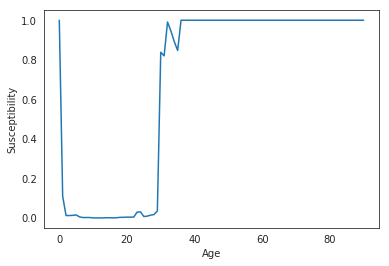

In [29]:
(1 - coverage*(0.9)).prod(axis=1).round(3).sort_index().plot()
plt.ylabel('Susceptibility')

In [11]:
downsample = lambda x: np.array([x[s].mean() for s in age_slices])

### Measles dynamics

$$\prod_{t=0}^T Pr(I_t | S_{t-1}, I_{t-1}) Pr(S_t | I_t, S_{t-1})$$

In [ ]:
with pm.Model() as model:
    
#     λ_p = pm.Pareto('λ_p', 1.5, 0.1)

#     a = p_μ * λ_p: mu*lam
#     b = (1 - p_μ) * λ_p

#     p_susceptible = pm.Beta('p_susceptible', a, b)
    
    R_0 = max(evs[np.isreal(evs)])
    
    # Initial susceptibles
    S_0 = pm.Gamma('S_0', )
    
    # Susceptibles
    S = S_0 - I.cumsum(axis=0)
    
    # Force of infection
    λ = S * (I.dot(B_prem) / N_age)
    
    # Effective reproductive number
    R_t = S.sum(1) * R_0 / N_age.sum()
    
    # Infections likelihood
    pm.Potential('infections', pm.Poisson.dist(lam[:-1]).logp(I[1:]))